# FBA and pFBA Simulations

By Christina Schenk and Garrett Roell

Tested on biodesign_3.7 kernel on jprime


This notebook performs flux balance analysis (FBA) and parsimonious FBA for R. opacus in glucose and phenol growth conditions and creates plots to compare the results with experimental data.

### Methods: 
<ol>
<li>Compare phenol 13CMFA fluxes to FBA and pFBA predictions: Scatter plots and flux maps</li>
<li>Compare glucose 13CMFA fluxes to FBA and pFBA predictions: Scatter plots and flux maps</li>
<li>Calculate FBA and pFBA growth rates for each of the experimental conditions</li>
<li>Plot growth rates in comparison to experimental data</li>
</ol>

#### The data uses the following mapping as introduced in Notebook E:

#### **Glucose**:
#### Yoneda transcriptomics data: 
* WT 1.0 g/L Glucose, 0.05g/L ammonium sulfate (**WT-LN-G**) (3 trials)

#### Combined with Rhiannon 2018 metabolomics and OD data:
* Metabolomics and OD data for WT Glucose (before **WT-G** but now **WT-LN-G**)

#### **Phenol**:
#### Henson data:
* WT 0.5 g/L Phenol (3 trials) (**WT-P**)
* PVHG6 0.5 g/L Phenol (3 trials) (**PVHG-P**)


### Imports

In [1]:
import pandas as pd
import numpy as np
import cobra
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.image as mpimg
import matplotlib.cm as cm
import scipy
from scipy.stats import linregress
from sklearn.metrics import r2_score

### Load data from consumption and growth rate notebook (notebook E)

In [2]:
consumption_and_growth_data = pd.read_csv('../consumption_and_growth_data/consumption_and_growth_data_new.csv', index_col=0)
consumption_and_growth_data

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279
PVHG-P,0.080331,0.040848,1.967485,0.002672,0.001757,0.021785
WT-LN-G,0.260195,0.072789,3.582471,0.004749,0.004117,0.141675


### Load model

In [3]:
model = cobra.io.read_sbml_model("../GSMs/Ropacus_annotated_curated.xml")

### **Phenol 13CMFA Comparison and Flux Maps**

##### **Load 13cdata**

#####  **Get 13C MFA measured fluxes for phenol**

In [4]:
phenol_fluxes = pd.read_csv('../13C_flux_data/13C_phenol_flux_data.csv')

# Remove rows that do not have a mapping to the GSM
phenol_fluxes.dropna(subset = ["Forward Reactions"], inplace=True)
print(f'There are {len(phenol_fluxes)} fluxes that can be compared between the MFA and FBA')
phenol_fluxes

There are 43 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000


#### WT-P

In [5]:
def FBA_pred(model, substrate, sub_uptake_rate=100):
    with model:
        medium = model.medium 
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            
            #remove all non-phenol carbon sources:
            medium["EX_glc__D_e"] = 0
            medium['EX_guaiacol_e'] = 0
            medium['EX_vanlt_e'] = 0
            medium['EX_tag'] = 0
            medium["EX_phenol_e"] = sub_uptake_rate
            
            model.reactions.get_by_id('EX_glc__D_e').upper_bound = 0
            model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
            
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            
            #remove all non-glucose carbon sources:
            medium["EX_phenol_e"] = 0
            medium['EX_guaiacol_e'] = 0
            medium['EX_vanlt_e'] = 0
            medium['EX_tag'] = 0
            medium["EX_glc__D_e"] = sub_uptake_rate
            
            model.reactions.get_by_id('EX_phenol_e').upper_bound = 0
            model.reactions.get_by_id('EX_phenol_e').lower_bound = 0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        fbasol = model.optimize()
        display(model.medium)
    return fbasol

In [6]:
def pFBA_pred(model, substrate, sub_uptake_rate=100):
    with model:
        medium = model.medium 
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            growth = 'Growth_Phenol'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            #remove all non-phenol carbon sources:
            medium["EX_glc__D_e"] = 0
            medium['EX_guaiacol_e'] = 0
            medium['EX_vanlt_e'] = 0
            medium['EX_tag'] = 0
            medium["EX_phenol_e"] = sub_uptake_rate
            
            model.reactions.get_by_id('EX_glc__D_e').upper_bound = 0
            model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0

        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            growth = 'Growth_Glucose'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            
            #remove all non-glucose carbon sources:
            medium["EX_phenol_e"] = 0
            medium['EX_guaiacol_e'] = 0
            medium['EX_vanlt_e'] = 0
            medium['EX_tag'] = 0
            medium["EX_glc__D_e"] = sub_uptake_rate

            model.reactions.get_by_id('EX_phenol_e').upper_bound = 0
            model.reactions.get_by_id('EX_phenol_e').lower_bound = 0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        try:
            pFBA_solution_all = cobra.flux_analysis.pfba(model)
        except:
            pFBA_solution_all = 0
            print("warning because of substrate cons rate for "+ index) 
        display(model.medium)
        
    return pFBA_solution_all

In [7]:
fbasol =  FBA_pred(model, 'phenol') 

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 100}

In [8]:
pfbasol =  FBA_pred(model, 'phenol') 

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 100}

#### **Plot solutions: Comparison of FBA predictions and 13c measurements**

##### **Add Phenol FBA and pFBA flux values to phenol fluxes dataframe**

In [9]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]

In [11]:
def add_pred_results_to_13CDF(df_13C, sol, method, strain):
    FBA_fluxes = []
    for _, row in df_13C.iterrows():
        reactions = row['Forward Reactions']
        flux_value = 0
        for x in [x.strip('() ') for x in reactions.split(' or ')]:
            and_split = [y.strip('() ') for y in x.split(' and ')]
            flux_value += min([get_flux_value(v, sol) for v in and_split])
        FBA_fluxes.append(flux_value)

    df_13C[str(method) + ' ' + str(strain) + ' ' + 'Value'] = FBA_fluxes
    return df_13C
    

##### **FBA**

In [13]:
phenol_fluxes =  add_pred_results_to_13CDF(phenol_fluxes, fbasol, 'FBA', 'WT')

In [14]:
phenol_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,FBA WT Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306,-1.505235
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683,-11.632455
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683,-11.632455
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683,-16.315977
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040,-31.656980
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040,-31.656980
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034,-42.149453
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034,-42.149453
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000,0.000000


##### **pFBA**

In [16]:
phenol_fluxes =  add_pred_results_to_13CDF(phenol_fluxes, pfbasol, 'pFBA', 'WT')

In [17]:
phenol_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,FBA WT Value,pFBA WT Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000,100.000000,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306,-1.505235,-1.505235
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683,-11.632455,-11.632455
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683,-11.632455,-11.632455
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683,-16.315977,-16.315977
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040,-31.656980,-31.656980
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040,-31.656980,-31.656980
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034,-42.149453,-42.149453
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034,-42.149453,-42.149453
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000,0.000000,0.000000


In [18]:
phenol_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,FBA WT Value,pFBA WT Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000,100.000000,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306,-1.505235,-1.505235
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683,-11.632455,-11.632455
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683,-11.632455,-11.632455
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683,-16.315977,-16.315977
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040,-31.656980,-31.656980
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040,-31.656980,-31.656980
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034,-42.149453,-42.149453
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034,-42.149453,-42.149453
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000,0.000000,0.000000


### **Plot FBA vs 13C MFA**

##### **FBA**

In [54]:
def scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate, method, strain):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    pathway_list = sorted(list(set(obspred_fluxes['Pathway']))) #sorted list such that same colors with every run
    for pathway in pathway_list:
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]

        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' ' + str(strain) + ' Value'])

        ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    predicted1 = obspred_fluxes.loc[~obspred_fluxes['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH']), str(method)+' '+ str(strain) + ' ' + 'Value']
    observed1 =  obspred_fluxes.loc[~obspred_fluxes['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH']),'Flux']
    
    predicted2 = obspred_fluxes.loc[:, str(method)+' '+ str(strain) + ' ' + 'Value']
    observed2 =  obspred_fluxes.loc[:,'Flux']
    
    r2_scikit_1 = r2_score(observed1,predicted1)
    r2_scikit_2 = r2_score(observed2,predicted2)
    
    mae_score_1 = np.round(mae_func(observed1, predicted1),2)
    mae_score_2 = np.round(mae_func(observed2, predicted2),2)
    


    if substrate=='phenol':
        plt.title(r''+ r"$\bf{" + str(method) + "}$"  + ': ' + f"$R^2$={r2_scikit_2:.2F} ({r2_scikit_1:.2F}$^\star$), MAE={mae_score_2} ({mae_score_1}$^\star$)", fontsize=18) #star: without 'ATP -> ATP.ext', 'NADH <-> NADPH'
    else:
        plt.title(r''+ r"$\bf{" + str(method) + "}$" + ': '+ f"$R^2$={r2_scikit_2:.2F}, MAE={mae_score_2}", fontsize=18)#r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes for ' +linename+ '\n' + f"$R^2$={r2_scikit_2:.2F} (all reactions)", fontsize=18)#, MAE={mae_score}, MSE = {mse}, RMSE={rmse}
    plt.xlabel(r'Observations', fontsize=18)#13C MFA fluxes (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r'Predictions', fontsize=18)#+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend(fontsize=14)
    plt.show()

In [55]:
def scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate, method, strain):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    pathway_list = sorted(list(set(obspred_fluxes['Pathway'])))
    for pathway in pathway_list:
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]
        
        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' ' +  str(strain) + ' Value'])
        if str(method) + ' ' +  str(strain) + ' std Value' in pathway_df.columns:
            simulated_std_list = list(pathway_df[str(method) + ' ' +  str(strain) + ' std Value'])
        measured_std_list = list(pathway_df['90% Confidence Upper Bound']-pathway_df['Flux'])
        
        
        sc = ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)
        if str(method) + ' ' +  str(strain) + ' std Value' in pathway_df.columns:
            ax.errorbar(
                measured_flux_list, simulated_flux_list, xerr=[std1 for std1 in measured_std_list], yerr=[1.9*std for std in simulated_std_list],
                    ecolor="gray", ls='none',
                    alpha=0.8)
        else: 
            ax.errorbar(
                measured_flux_list, simulated_flux_list, xerr=[std1 for std1 in measured_std_list],
                    ecolor="gray", ls='none',
                    alpha=0.8)

    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    predicted1 = obspred_fluxes.loc[~obspred_fluxes['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH']), str(method)+' '+ str(strain) + ' ' + 'Value']
    observed1 =  obspred_fluxes.loc[~obspred_fluxes['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH']),'Flux']
    
    predicted2 = obspred_fluxes.loc[:, str(method)+' '+ str(strain) + ' ' + 'Value']
    observed2 =  obspred_fluxes.loc[:,'Flux']
    
    r2_scikit_1 = r2_score(observed1,predicted1)
    r2_scikit_2 = r2_score(observed2,predicted2)
       
    mae_score_1 = np.round(mae_func(observed1, predicted1),2)
    mae_score_2 = np.round(mae_func(observed2, predicted2),2)
    


    if substrate=='phenol':
        plt.title(r''+ r"$\bf{" + str(method) + "}$"  + ': ' + f"$R^2$={r2_scikit_2:.2F} ({r2_scikit_1:.2F}$^\star$), MAE={mae_score_2} ({mae_score_1}$^\star$)", fontsize=18) #star: without 'ATP -> ATP.ext', 'NADH <-> NADPH'
    else:
        plt.title(r''+ r"$\bf{" + str(method) + "}$" + ': '+ f"$R^2$={r2_scikit_2:.2F}, MAE={mae_score_2}", fontsize=18)#r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes for ' +linename+ '\n' + f"$R^2$={r2_scikit_2:.2F} (all reactions)", fontsize=18)#, MAE={mae_score}, MSE = {mse}, RMSE={rmse}
    plt.ylabel(r'Predictions', fontsize=18)#+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend(fontsize=14)
    plt.show()

define function to calculate mean absolute error

In [21]:
def mae_func(observed, predicted):
    """Mean Absolute Error.
    Multioutput case included."""

    if observed.ndim == 1:
        return np.mean(np.abs([y_o - y_p for y_o, y_p in zip(observed, predicted)]))
    else:
        return [
            np.mean(
                np.abs([y_o - y_p for y_o, y_p in zip(observed[:, i], predicted[:, i])])
            )
            for i in range(observed.shape[1])
        ]

##### Scatter plot: 13CMFA vs.FBA

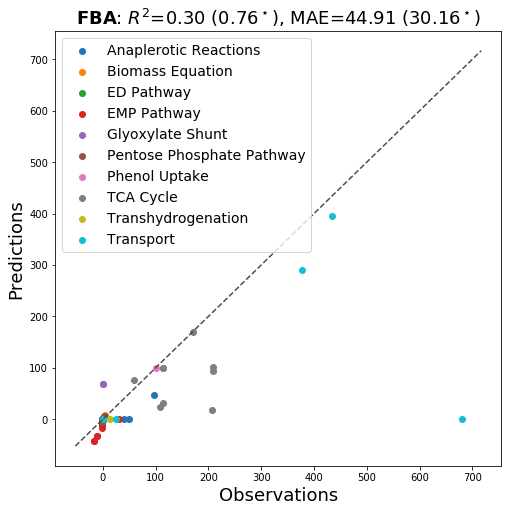

In [57]:
scatterplotcomp_obs_vs_pred(phenol_fluxes, substrate='phenol', method='FBA', strain='WT')

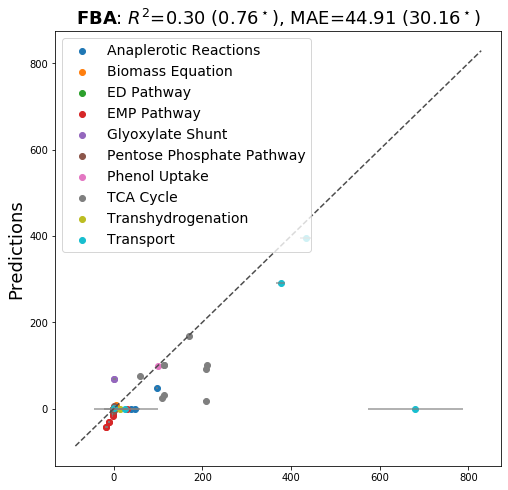

In [56]:
scatterplotcomp_obs_vs_pred_withstd(phenol_fluxes, substrate='phenol', method='FBA', strain='WT')

##### **pFBA**

##### Scatter plot: 13CMFA vs. pFBA

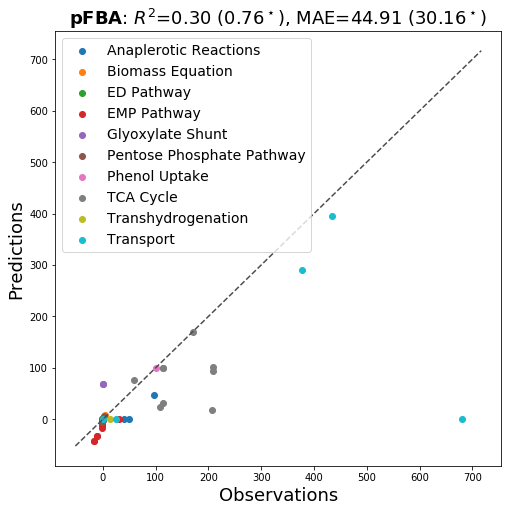

In [58]:
scatterplotcomp_obs_vs_pred(phenol_fluxes, substrate='phenol', method='pFBA', strain='WT')

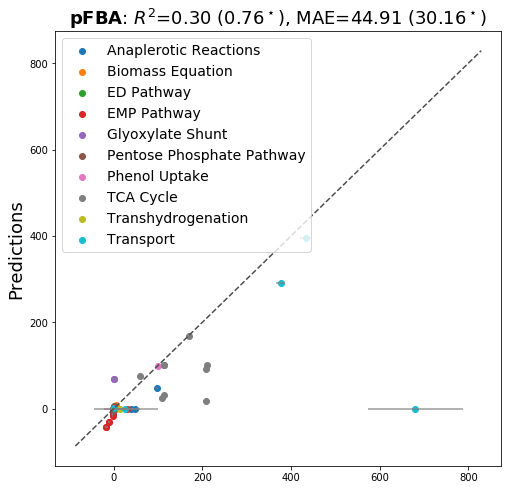

In [59]:
scatterplotcomp_obs_vs_pred_withstd(phenol_fluxes, substrate='phenol', method='pFBA', strain='WT')

Define a function to convert a predicted flux data frame column to a flux map

In [60]:
def map_flux_results(data_df, flux_column):
    fig, ax = plt.subplots(figsize=(15, 20), dpi=50)
    xy = (0.5, 0.5)
    arr_img = plt.imread('./unlabeled_flux_map.png')
    imagebox = OffsetImage(arr_img)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy, frameon=False)
    ax.add_artist(ab)

    for _, row in data_df.iterrows():
        if not pd.isnull(row['Location on map']):
            location =  row['Location on map'].replace('(', '').replace(')', '')
            location_list = location.split(',')
            location_tuple = tuple((int(location_list[0]), int(location_list[1])))

            offsetbox = TextArea(f'{row[flux_column]:.1f}',textprops=dict(fontsize=22))
            ab = AnnotationBbox(offsetbox, xy,
                                xybox=location_tuple,
                                xycoords='data',
                                boxcoords="offset points",
                                frameon=False)
            ax.add_artist(ab)

    # Fix the display limits to see everything
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

    plt.show()

### Map FBA Fluxes

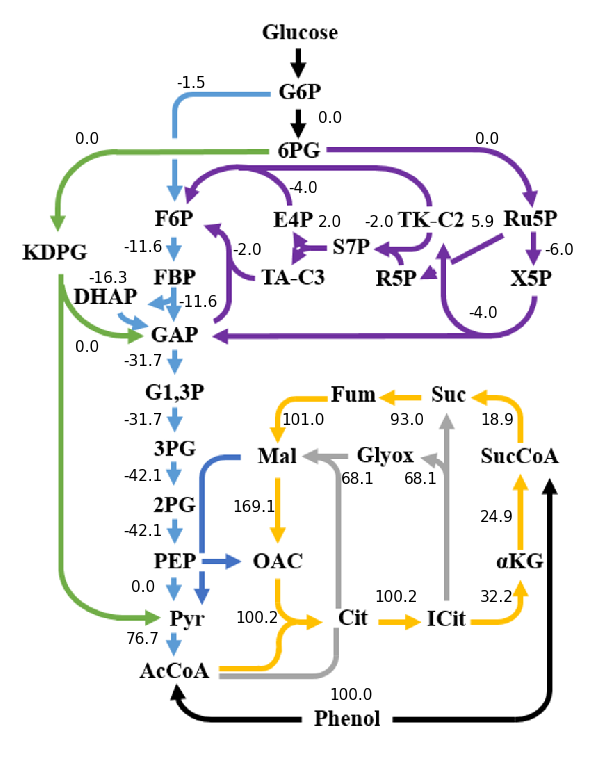

In [61]:
map_flux_results(phenol_fluxes, 'FBA WT Value')

### Map pFBA Fluxes

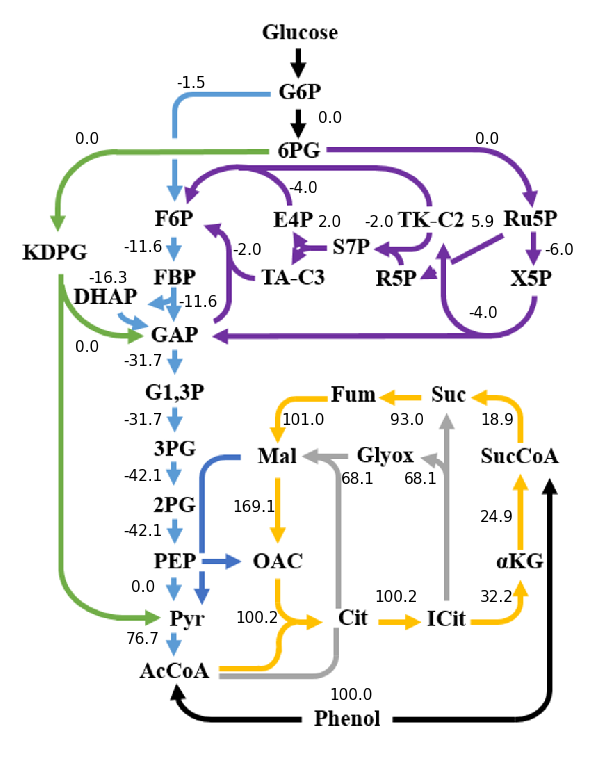

In [62]:
map_flux_results(phenol_fluxes, 'pFBA WT Value')

### Map 13C MFA Fluxes

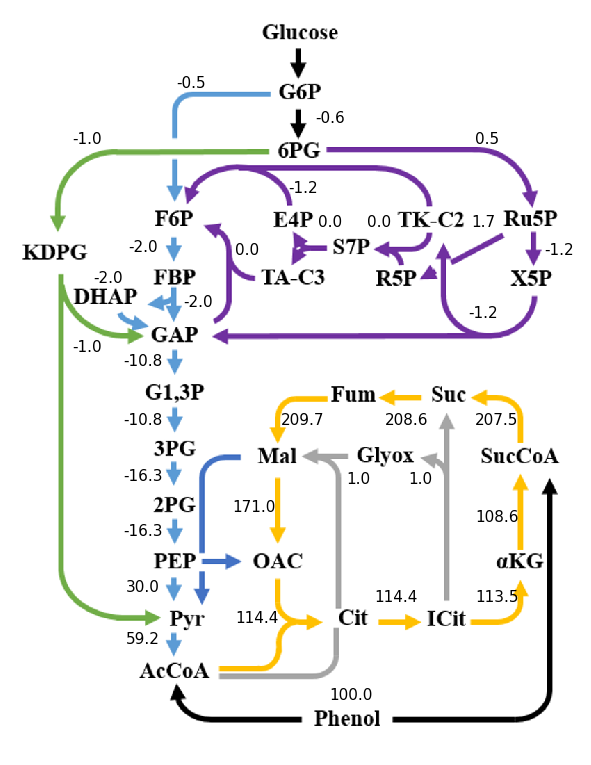

In [63]:
map_flux_results(phenol_fluxes, 'Flux')

In [64]:
phenol_fluxes.to_csv('../13C_flux_data/13C_phenol_flux_and_FBA_pFBA_data.csv')

### **Glucose 13CMFA Comparison and Flux Maps**

##### **Load 13cdata**

#####  **Get 13C MFA measured fluxes for glucose**

In [65]:
glucose_fluxes = pd.read_csv('../13C_flux_data/13C_glucose_flux_data.csv')

# Remove rows that do not have a mapping to the GSM
glucose_fluxes.dropna(inplace=True)
print(f'There are {len(glucose_fluxes)} fluxes that can be compared between the MFA and FBA')
glucose_fluxes

There are 31 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00


### Run glucose flux FBA

In [66]:
fbasol_glu =  FBA_pred(model, 'glucose') 

{'EX_glc__D_e': 100,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

### Add Glucose FBA flux values to glucose_fluxes dataframe

##### **FBA**

In [67]:
glucose_fluxes =  add_pred_results_to_13CDF(glucose_fluxes, fbasol_glu, 'FBA', 'WT')

### Run glucose flux pFBA

In [68]:
pfbasol_glu =  pFBA_pred(model, 'glucose') 

{'EX_glc__D_e': 100,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

### Add Glucose FBA flux values to glucose_fluxes dataframe

##### **pFBA**

In [69]:
glucose_fluxes =  add_pred_results_to_13CDF(glucose_fluxes, pfbasol_glu, 'pFBA', 'WT')

### Plot FBA vs 13C MFA

##### **FBA**

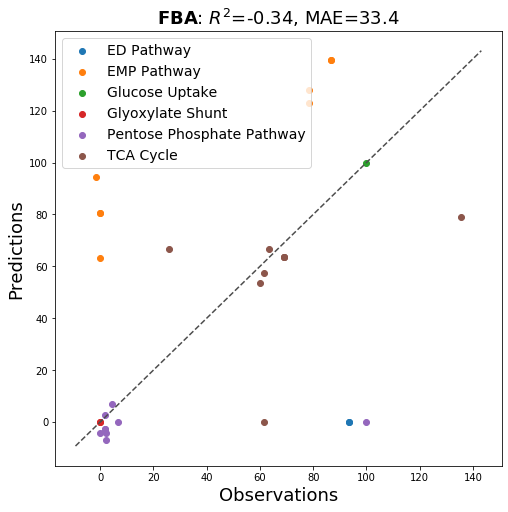

In [70]:
scatterplotcomp_obs_vs_pred(glucose_fluxes, substrate='glucose', method='FBA', strain='WT')

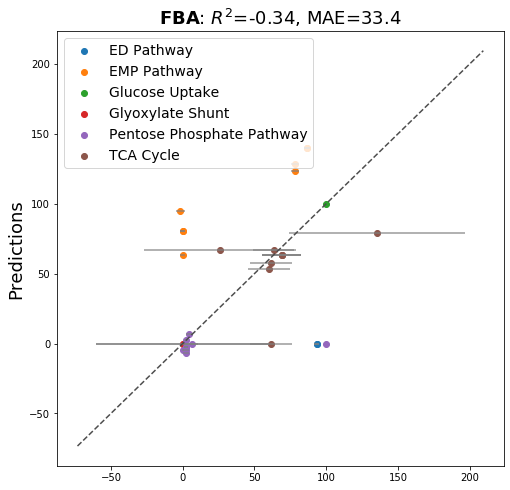

In [71]:
scatterplotcomp_obs_vs_pred_withstd(glucose_fluxes, substrate='glucose', method='FBA', strain='WT')

##### **pFBA**

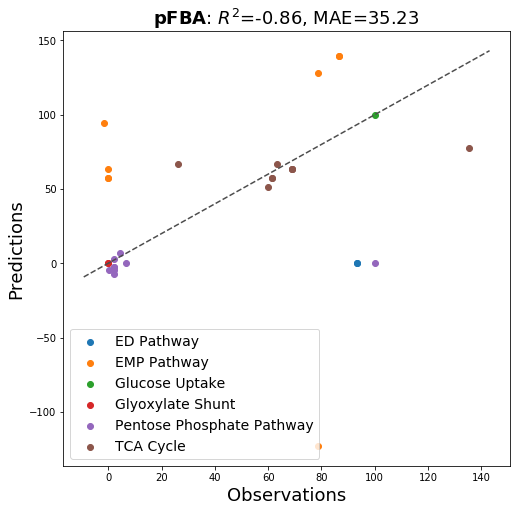

In [72]:
scatterplotcomp_obs_vs_pred(glucose_fluxes, substrate='glucose', method='pFBA', strain='WT')

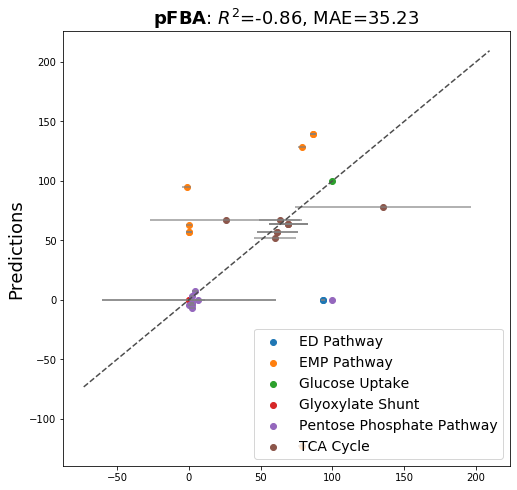

In [73]:
scatterplotcomp_obs_vs_pred_withstd(glucose_fluxes, substrate='glucose', method='pFBA', strain='WT')

### Map FBA Fluxes

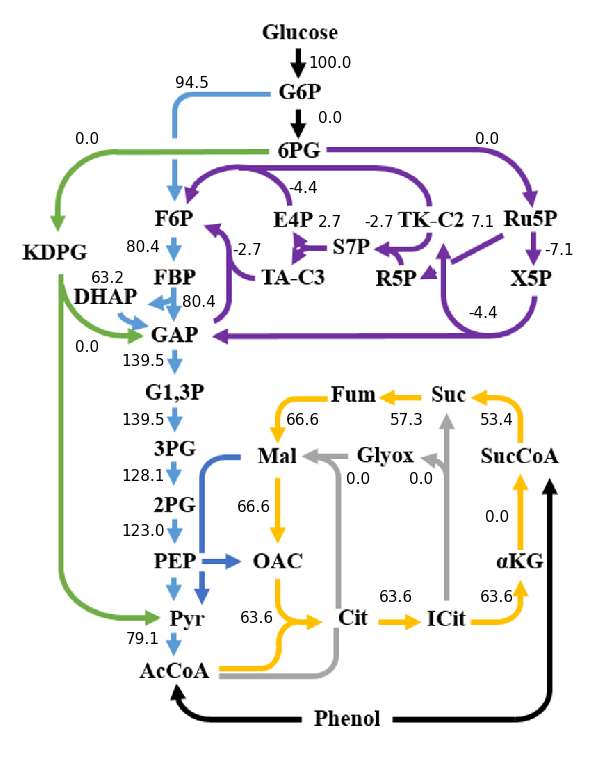

In [74]:
map_flux_results(glucose_fluxes, 'FBA WT Value')

### Map pFBA Fluxes

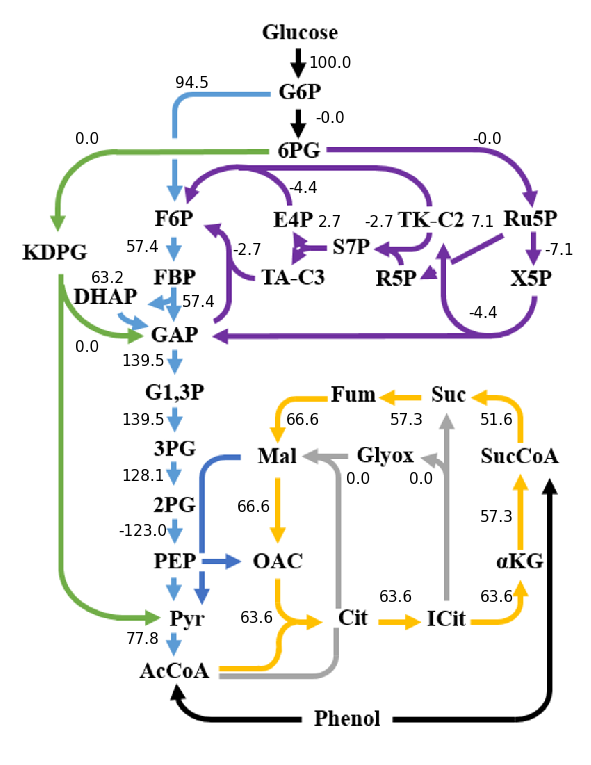

In [75]:
map_flux_results(glucose_fluxes, 'pFBA WT Value')

### Map 13C MFA Fluxes

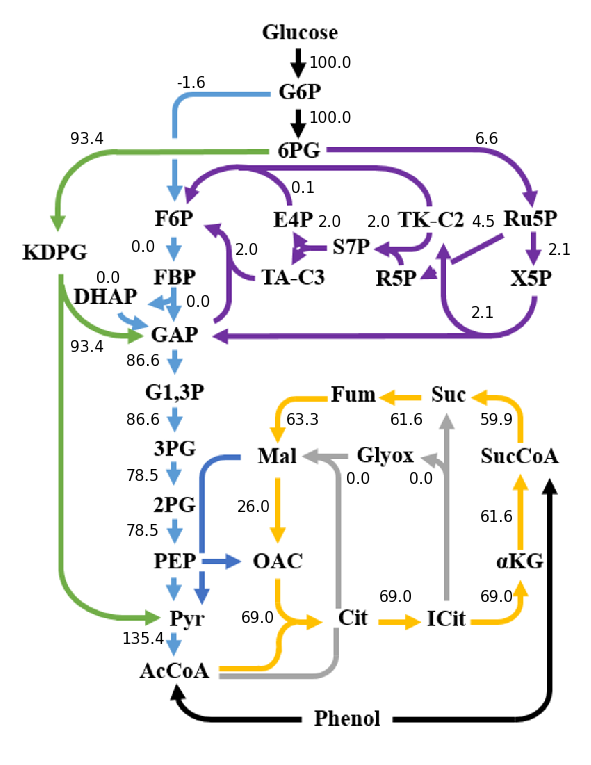

In [76]:
map_flux_results(glucose_fluxes, 'Flux')

In [77]:
glucose_fluxes.to_csv('../13C_flux_data/13C_glucose_flux_and_FBA_pFBA_data.csv')

#### **Calculate growth rate predictions via FBA and pFBA**

In [78]:
consumption_and_growth_data['FBA_growth_rate']=pd.Series(np.zeros(len(consumption_and_growth_data['growth rate'])), index=consumption_and_growth_data.index)
consumption_and_growth_data['pFBA_growth_rate']=pd.Series(np.zeros(len(consumption_and_growth_data['growth rate'])), index=consumption_and_growth_data.index)
display(consumption_and_growth_data)

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev,FBA_growth_rate,pFBA_growth_rate,FBA growth rate,pFBA growth rate
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279,0.0,0.0,0.126338,0.126338
PVHG-P,0.080331,0.040848,1.967485,0.002672,0.001757,0.021785,0.0,0.0,0.183842,0.183842
WT-LN-G,0.260195,0.072789,3.582471,0.004749,0.004117,0.141675,0.0,0.0,0.431091,0.431091


##### Calculate FBA and pFBA growth rates and add to data frame

In [79]:
FBA_growth_rates = []
pFBA_growth_rates = []
for index in consumption_and_growth_data.index:
    sub_uptake_rate = consumption_and_growth_data.loc[index,'substrate consumption rate']
    if '-P' in str(index):
        substrate='phenol'
        growth = 'Growth_Phenol'
    elif '-G' in str(index):
        substrate='glucose'
        growth = 'Growth_Glucose'
    FBA_sol = FBA_pred(model, substrate, sub_uptake_rate)
    display(FBA_sol.fluxes['Growth_Glucose'])
    display(FBA_sol.fluxes[growth])
    FBA_growth_sol = FBA_sol.fluxes[growth]
    pFBA_sol = pFBA_pred(model, substrate, sub_uptake_rate)
    pFBA_growth_sol = pFBA_sol.fluxes[growth]
    
    FBA_growth_rates.append(FBA_growth_sol)
    pFBA_growth_rates.append(pFBA_growth_sol)
    
consumption_and_growth_data['FBA growth rate'] = FBA_growth_rates
consumption_and_growth_data['pFBA growth rate'] = pFBA_growth_rates
consumption_and_growth_data
    

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1.3520722607432194}

0.0

0.12633790630146932

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1.3520722607432194}

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1.96748494522118}

0.0

0.1838421923708941

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1.96748494522118}

{'EX_glc__D_e': 3.582470920816068,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

0.43109119037136007

0.43109119037136007

{'EX_glc__D_e': 3.582470920816068,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev,FBA_growth_rate,pFBA_growth_rate,FBA growth rate,pFBA growth rate
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279,0.0,0.0,0.126338,0.126338
PVHG-P,0.080331,0.040848,1.967485,0.002672,0.001757,0.021785,0.0,0.0,0.183842,0.183842
WT-LN-G,0.260195,0.072789,3.582471,0.004749,0.004117,0.141675,0.0,0.0,0.431091,0.431091


dX/dt = mu*X

unit of substrate uptake rate = mmol substrate / (1 g biomass * hr)
units of biomass flux         = g biomass / (1 g biomass * hr) 
biomass flux = mu 

### Plot predicted vs measured growth rates

define function to calculate root mean squared error

In [80]:
def rmse_func(predicted, observed):
    return np.sqrt(((predicted - observed) ** 2).mean())

##### define function for mse

In [81]:
def mse_func(predicted, observed):
    rss = np.sum((predicted - observed) ** 2) 
    mse = np.round(1/len(observed) * rss,2) 
    return mse

define function to compare growth rates in scatter plot

In [82]:
def scatter_plot_compare(observed, predicted, labels, method):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    lims = [
                np.min([observed, predicted]),  # min of both axes
                np.max([observed, predicted]),  # max of both axes
            ]
    ax.set_xlim(lims)
    
    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    for i in range(0, len(observed)):
        ax.scatter(observed[i], predicted[i])
        ax.annotate(str(labels[i]),(observed[i],predicted[i]), fontsize=14)
        
    #calculate statistical quantities:
    r2 = r2_score(observed,predicted)
    #mse = np.round(mse_func(predicted, observed),2)
    #rmse = np.round(rmse_func(predicted, observed),2)
    mae_score = np.round(mae_func(observed, predicted),2)

    
    plt.xlabel(r'Observations', fontsize=18)#ed growth rate [$mmol/gDW/hr$]',fontsize=14)
    plt.ylabel(r'Predictions', fontsize=18)#ed growth rate [$mmol/gDW/hr$]', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(r''+ r"$\bf{" + str(method) + "}$" +': '+ f"$R^2$={r2:.2F}, MAE={mae_score}", fontsize=18)#Growth rates: Observed vs. Predicted ('+strtitle+'), \n'
    #plt.title(r''+ r"$\bf{" + str(method) + "}$" +': '+ f"$R^2$={r2:.2F}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)#Growth rates: Observed vs. Predicted ('+strtitle+'), \n'
    plt.show()

##### **Define list to just select the indices that correspond to the data that we have transcripts available for**

In [83]:
selectedlist = ['WT-P', 'PVHG-P', 'WT-LN-G']

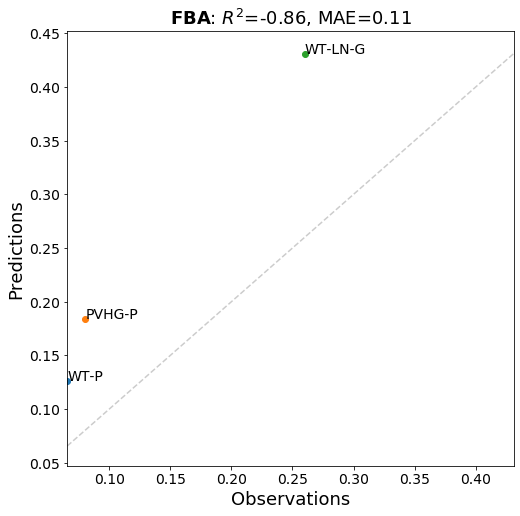

In [84]:
scatter_plot_compare(consumption_and_growth_data.loc[selectedlist, 'growth rate'], consumption_and_growth_data.loc[selectedlist, 'FBA growth rate'], selectedlist, 'FBA')

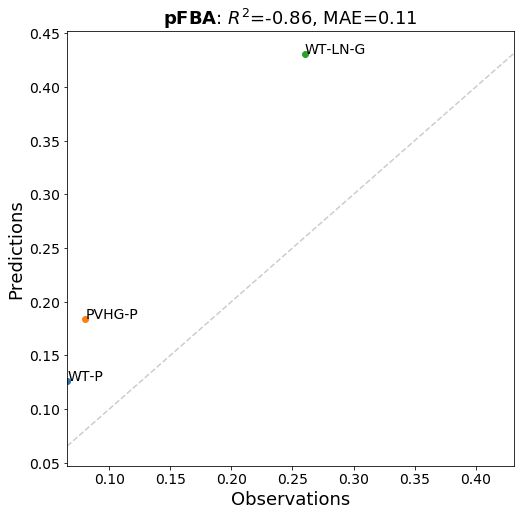

In [85]:
scatter_plot_compare(consumption_and_growth_data.loc[selectedlist, 'growth rate'], consumption_and_growth_data.loc[selectedlist, 'pFBA growth rate'], selectedlist, 'pFBA')